In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d, CubicSpline
import warnings
from tqdm.auto import tqdm

In [10]:
font = {'size'   : 16}
plt.rc('font', **font)
plt.rcParams["font.family"] = "Arial"
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
K2Har = 3.166811563e-6     # Kelvin to Hartree
Boh2m = 5.2917710903e-11   # Bohr radius (length in atu)
u2me = 1.8228884862e3      # atomic mass (amu or u) to m_e : atomic unit mass (a.u.)
J2Har = 2.2937122783963e17 # Joule to Hartree
Har2invcm = 2.194746313632e5 # Hartree to cm-1
ttos = 2.4188843265857e-17 # atomic time to seconds
autocm = 5.2918e-9 # Bohr to cm

In [4]:
# Define masses
m_He= 4*u2me
m_Ca = 40*u2me
m_H = 1.008*u2me
m_H2 = 2*m_H
m_CaH = m_Ca + m_H
m_CaH2 = m_Ca + m_H2

mu_CaHe = m_He*m_Ca/(m_He+m_Ca)
mu_CaHHe = m_He*(m_CaH)/(m_CaH+m_He)
mu_CaH = m_Ca*m_H/(m_Ca+m_H)
mu_CaH2 = m_Ca*(m_H + m_H)/(m_Ca+m_H+m_H)

k_CaH = (m_Ca + m_H)**2/(2*m_Ca*m_H)
k_CaHe = (m_Ca + m_He)**2/(2*m_Ca*m_He)
k_CaH2 = (m_Ca + m_H2)**2/(2*m_Ca*m_H2)
k_CaHHe = (m_CaH + m_He)**2/(2*m_CaH*m_He)
k_CaHH2 = (m_CaH + m_H2)**2/(2*m_CaH*m_H2)

### Import QCT simulation data, calculate rates

In [ ]:
# Import data (from rawdata.zip)
v0j0 =  pd.read_csv('data/v0j0.txt')
v1j0 =  pd.read_csv('data/v1j0.txt')
v2j0 =  pd.read_csv('data/v2j0.txt')

In [66]:
data = pd.concat([v0j0,v1j0,v2j0])

In [67]:
# Total rate calulation

# Opacity = Np/N
stats = data.groupby(['e','b','vi','ji']).sum().loc[:,:'nd']
nTraj = stats[['n12','n23','n31','nd']].sum(axis=1)

opac = pd.DataFrame(index=stats.index)
opac['nR'] = stats['n23'] + stats['n31']
opac['nT'] = stats.sum(axis=1)
opac['pR'] = opac['nR']/opac['nT']
opac['pR_err'] = np.sqrt(opac['nR']*(opac['nT']-opac['nR'])/opac['nT'])/opac['nT']
opac['pQ'] = stats['n12']/opac['nT']
opac['pQ_err'] = np.sqrt(stats['n12']*(opac['nT']-stats['n12'])/opac['nT'])/opac['nT']

# Cross section = integral(opacity), x = b
op = opac.reset_index()
fact_sig = (Boh2m*1e2)**2 # bohr^2 to cm^2
def integ(integrand, x):
    return 2*np.pi*integrate.trapezoid(integrand, x=x)
sigma = pd.DataFrame()
sigma['sig_R'] = op.groupby(['vi','ji','e']).apply(lambda g: \
                                                   integ(g.pR*g.b, x = g.b), include_groups=False)*fact_sig
sigma['sig_Rerr'] = op.groupby(['vi','ji','e']).apply(lambda g: \
                                                       integ(g.pR_err*g.b, x=g.b), include_groups=False)*fact_sig
sigma['sig_Q'] = op.groupby(['vi','ji','e']).apply(lambda g: \
                                                   integ(g.pQ*g.b, x = g.b), include_groups=False)*fact_sig
sigma['sig_Qerr'] = op.groupby(['vi','ji','e']).apply(lambda g: \
                                                      integ(g.pQ_err*g.b, x=g.b), include_groups=False)*fact_sig

# Rate = sigma*v
fact_k3 = (Boh2m*1e2)/ttos # sigma*v [cm/s]
rate = sigma.copy()
rate['P0'] = np.sqrt(rate.index.get_level_values('e')*2*mu_CaH2*K2Har)
rate[['sig_R','sig_Rerr','sig_Q','sig_Qerr']] = \
        rate[['sig_R','sig_Rerr','sig_Q','sig_Qerr',]].multiply(rate['P0']/mu_CaH2*fact_k3, axis='index')
rate = rate.rename(columns = {'sig_R':'k_R','sig_Rerr':'k_Rerr',
                           'sig_Q':'k_Q','sig_Qerr':'k_Qerr'})

In [68]:
# State-specific rate calulation

# Sort by final v
stats = data.groupby(['e','b','vi','ji','v']).sum().loc[:,:'nd']
nTraj = data.groupby(['e','b','vi','ji'])[['n12','n23','n31','nd']].sum()

opac_v = pd.DataFrame(index=stats.index)
opac_v['nR'] = stats['n23'] + stats['n31']
opac_v['nQ'] = stats['n12']
opac_v['nT'] = nTraj.sum(axis=1)
opac_v['pR'] = opac_v['nR']/opac_v['nT']
opac_v['pR_err'] = np.sqrt(opac_v['nR']*(opac_v['nT']-opac_v['nR'])/opac_v['nT'])/opac_v['nT']
opac_v['pQ'] = stats['n12']/opac_v['nT']
opac_v['pQ_err'] = np.sqrt(stats['n12']*(opac_v['nT']-stats['n12'])/opac_v['nT'])/opac_v['nT']

# Drop duplicates for elastic collisions
opac_v = opac_v.reset_index().sort_values(['vi','ji','e','b']).drop_duplicates(subset=['vi','ji','e','pQ','v']) # Cut off elastic

# Cross section = integral(opacity), x = b
op = opac_v.reset_index()
fact_sig = (Boh2m*1e2)**2 # bohr^2 to cm^2
def integ(integrand, x):
    return 2*np.pi*integrate.trapezoid(integrand, x=x)
sigma_v = pd.DataFrame()
sigma_v['sig_R'] = op.groupby(['vi','ji','e','v']).apply(lambda g: \
                                                   integ(g.pR*g.b, x = g.b), include_groups=False)*fact_sig
sigma_v['sig_Rerr'] = op.groupby(['vi','ji','e','v']).apply(lambda g: \
                                                       integ(g.pR_err*g.b, x=g.b), include_groups=False)*fact_sig
sigma_v['sig_Q'] = op.groupby(['vi','ji','e','v']).apply(lambda g: \
                                                   integ(g.pQ*g.b, x = g.b), include_groups=False)*fact_sig
sigma_v['sig_Qerr'] = op.groupby(['vi','ji','e','v']).apply(lambda g: \
                                                      integ(g.pQ_err*g.b, x=g.b), include_groups=False)*fact_sig

# Rate = sigma*velocity
fact_k3 = (Boh2m*1e2)/ttos # sigma*v [cm/s]
rate_v = sigma_v.copy()
rate_v['P0'] = np.sqrt(rate_v.index.get_level_values('e')*2*mu_CaH2*K2Har)
rate_v[['sig_R','sig_Rerr','sig_Q','sig_Qerr']] = \
        rate_v[['sig_R','sig_Rerr','sig_Q','sig_Qerr',]].multiply(rate_v['P0']/mu_CaH2*fact_k3, axis='index')
rate_v = rate_v.rename(columns = {'sig_R':'k_R','sig_Rerr':'k_Rerr',
                           'sig_Q':'k_Q','sig_Qerr':'k_Qerr'})

In [69]:
kq_cut = rate_v.copy()
kq_cut.loc[(kq_cut['k_Qerr']/kq_cut['k_Q']) > 0.15, 'k_Q'] = 0.0
kq_cut.loc[(kq_cut['k_Qerr']/kq_cut['k_Q']) > 0.15, 'k_Qerr'] = 0.0
kr_cut = rate.copy()
kr_cut.loc[(kr_cut['k_Rerr']/kr_cut['k_R']) > 0.15, 'k_R'] = 0.0
kr_cut.loc[(kr_cut['k_Rerr']/kr_cut['k_R']) > 0.15, 'k_Rerr'] = 0.0

In [ ]:
# Save
opac.to_csv('data/opacity.txt')
opac_v.to_csv('data/opacity_v.txt')
sigma.to_csv('data/cross_section.txt')
sigma_v.to_csv('data/cross_section_v.txt')
rate.to_csv('data/rate.txt')
rate_v.to_csv('data/rate_v.txt')

In [14]:
# If data unavailable, use rate files
rate = pd.read_csv('data/rate.txt')
rate_v = pd.read_csv('data/rate_v.txt')

### Temperature dependent rate via Maxwell-Boltzmann distribution

In [70]:
kq_v = kq_cut.copy().reset_index() # For state-specific quenching
kr = kr_cut.copy().reset_index() # For CaH formation (all states)

kquench = {}
kquench_err = {}
kreac = {}
kreac_err = {}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for t in range(1,5000,10):
        kquench[t] = kq_v.groupby(['vi','ji','v']).apply(lambda g: integrate.trapz(
            2*np.sqrt(g.e/np.pi)*g.k_Q*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
        kquench_err[t] = kq_v.groupby(['vi','ji','v']).apply(lambda g: integrate.trapz(
            2*np.sqrt(g.e/np.pi)*g.k_Qerr*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
        kreac[t] = kr.groupby(['vi','ji']).apply(lambda g: integrate.trapz(
            2*np.sqrt(g.e/np.pi)*g.k_R*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
        kreac_err[t] = kr.groupby(['vi','ji']).apply(lambda g: integrate.trapz(
            2*np.sqrt(g.e/np.pi)*g.k_Rerr*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
    for t in range(5000,10000,100):
        kquench[t] = kq_v.groupby(['vi','ji','v']).apply(lambda g: integrate.trapezoid(
            2*np.sqrt(g.e/np.pi)*g.k_Q*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
        kquench_err[t] = kq_v.groupby(['vi','ji','v']).apply(lambda g: integrate.trapezoid(
            2*np.sqrt(g.e/np.pi)*g.k_Qerr*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
        kreac[t] = kr.groupby(['vi','ji']).apply(lambda g: integrate.trapezoid(
            2*np.sqrt(g.e/np.pi)*g.k_R*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))
        kreac_err[t] = kr.groupby(['vi','ji']).apply(lambda g: integrate.trapezoid(
            2*np.sqrt(g.e/np.pi)*g.k_Rerr*(1/t)**(3/2)*np.exp(-g.e/t), x = g.e))    
# State-specific thermal quenching rates, index: vi, ji, vf
kqt = pd.DataFrame.from_dict(kquench)
kqt_err = pd.DataFrame.from_dict(kquench_err)

# Reactive thermal reactive rates, index: vi, ji
krt = pd.DataFrame.from_dict(kreac)
krt_err = pd.DataFrame.from_dict(kreac_err)

# Interpolation
Tx = np.arange(1,5000,10)
fkq01 = interp1d(kqt.loc[0,0,1].index.astype(int),kqt.loc[0,0,1].values) # H2(0,0) -> H2(1,j)
fkq10 = interp1d(kqt.loc[1,0,0].index.astype(int),kqt.loc[1,0,0].values) # H2(1,0) -> H2(0,j)
fkq02 = interp1d(kqt.loc[0,0,2].index.astype(int),kqt.loc[0,0,2].values) # H2(0,0) -> H2(2,j)
fkq12 = interp1d(kqt.loc[1,0,2].index.astype(int),kqt.loc[1,0,2].values) # H2(1,0) -> H2(2,j)
fkq20 = interp1d(kqt.loc[2,0,0].index.astype(int),kqt.loc[2,0,0].values) # H2(2,0) -> H2(0,j)
fkq21 = interp1d(kqt.loc[2,0,1].index.astype(int),kqt.loc[2,0,1].values) # H2(2,0) -> H2(1,j)
fkr0 = interp1d(krt.loc[0,0].index.astype(int),krt.loc[0,0].values) # Ca + H2(0,0) -> CaH
fkr1 = interp1d(krt.loc[1,0].index.astype(int),krt.loc[1,0].values) # Ca + H2(1,0) -> CaH
fkr2 = interp1d(krt.loc[2,0].index.astype(int),krt.loc[2,0].values) # Ca + H2(2,0) -> CaH

fkq01_err = interp1d(kqt_err.loc[0,0,1].index.astype(int),kqt_err.loc[0,0,1].values)
fkq10_err = interp1d(kqt_err.loc[1,0,0].index.astype(int),kqt_err.loc[1,0,0].values)
fkq02_err = interp1d(kqt_err.loc[0,0,2].index.astype(int),kqt_err.loc[0,0,2].values)
fkq12_err = interp1d(kqt_err.loc[1,0,2].index.astype(int),kqt_err.loc[1,0,2].values)
fkq20_err = interp1d(kqt_err.loc[2,0,0].index.astype(int),kqt_err.loc[2,0,0].values)
fkq21_err = interp1d(kqt_err.loc[2,0,1].index.astype(int),kqt_err.loc[2,0,1].values)
fkr0_err = interp1d(krt_err.loc[0,0].index.astype(int),krt_err.loc[0,0].values)
fkr1_err = interp1d(krt_err.loc[1,0].index.astype(int),krt_err.loc[1,0].values)
fkr2_err = interp1d(krt_err.loc[2,0].index.astype(int),krt_err.loc[2,0].values)

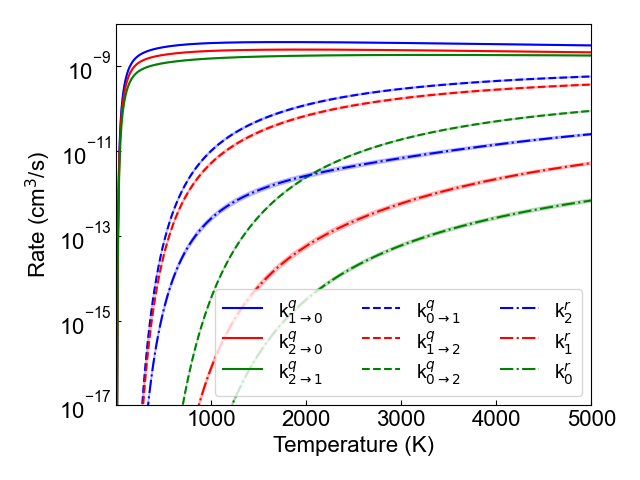

In [71]:
#----- FIG 6 -----#
from matplotlib.ticker import FormatStrFormatter
minx, maxx = 10,7000
x = np.arange(minx,maxx,10)

plt.figure()

plt.plot(x, fkq10(x), color = 'b',label = r'k$^q_{1\rightarrow 0}$')
plt.fill_between(x,fkq10(x)-fkq10_err(x), 
                 fkq10(x)+fkq10_err(x),color = 'b',alpha=0.2)
plt.plot(x, fkq20(x), color = 'r',label = r'k$^q_{2\rightarrow 0}$')
plt.fill_between(x,fkq20(x)-fkq20_err(x),
                  fkq20(x)+fkq20_err(x),color = 'r',alpha=0.2)
plt.plot(x, fkq21(x), color = 'g',label = r'k$^q_{2\rightarrow 1}$')
plt.fill_between(x,fkq21(x)-fkq21_err(x), 
                 fkq21(x)+fkq21_err(x),color = 'g',alpha=0.2)
plt.plot(x, fkq01(x), '--', color = 'b',label = r'k$^q_{0\rightarrow 1}$')
plt.fill_between(x,(fkq01(x)-fkq01_err(x)), 
                 (fkq01(x)+fkq01_err(x)),color = 'b',alpha=0.2)
plt.plot(x, fkq12(x), '--', color = 'r',label = r'k$^q_{1\rightarrow 2}$')
plt.fill_between(x,(fkq12(x)-fkq12_err(x)), 
                 (fkq12(x)+fkq12_err(x)),color = 'r',alpha=0.2)
plt.plot(x, fkq02(x), '--', color = 'g',label = r'k$^q_{0\rightarrow 2}$')
plt.fill_between(x,(fkq02(x)-fkq02_err(x)), 
                 (fkq02(x)+fkq02_err(x)),color = 'g',alpha=0.2)

# plt.plot(x, fkq23(x), '--', color = 'orange',label = r'k$^q_{23}$')
# plt.fill_between(x,(fkq23(x)-fkq23_err(x)), 
#                  (fkq23(x)+fkq23_err(x)),color = 'orange',alpha=0.2)

# plt.plot(x, fkq30(x), color = 'b',label = r'k$^q_{30}$')
# plt.fill_between(x,(fkq30(x)-fkq30_err(x)), 
#                  (fkq30(x)+fkq30_err(x)),color = 'b',alpha=0.2)
# plt.plot(x, fkq31(x), color = 'r',label = r'k$^q_{31}$')
# plt.fill_between(x,(fkq31(x)-fkq31_err(x)), 
#                  (fkq31(x)+fkq31_err(x)),color = 'r',alpha=0.2)
# plt.plot(x, fkq32(x), color = 'g',label = r'k$^q_{32}$')
# plt.fill_between(x,(fkq32(x)-fkq32_err(x)), 
#                  (fkq32(x)+fkq32_err(x)),color = 'g',alpha=0.2)

# plt.plot(x,fkr3(x),'-.', label=r'k$^r_{3}$',color = 'orange')
# plt.fill_between(x,(fkr3(x)-fkr3_err(x)), 
#                  (fkr3(x)+fkr3_err(x)),alpha=0.2,color = 'orange')
plt.plot(x,fkr2(x),'-.', label=r'k$^r_{2}$',color = 'b')
plt.fill_between(x,(fkr2(x)-fkr2_err(x)), 
                 (fkr2(x)+fkr2_err(x)),alpha=0.2,color = 'b')
plt.plot(x,fkr1(x),'-.', label=r'k$^r_{1}$',color = 'r')
plt.fill_between(x,(fkr1(x)-fkr1_err(x)), 
                 (fkr1(x)+fkr1_err(x)),alpha=0.2,color = 'r')
plt.plot(x,fkr0(x),'-.', color = 'g',label=r'k$^r_{0}$')
plt.fill_between(x,(fkr0(x)-fkr0_err(x)), 
                 (fkr0(x)+fkr0_err(x)) , color = 'g',alpha=0.2)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1e-17,1e-8)
plt.xlim(6,5000)
plt.legend(fontsize=14, ncol=3, handleheight=2.0, labelspacing=0.02)
# plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate (cm$^3$/s)')
plt.tight_layout()

# plt.savefig('all_rates_log.svg')
# plt.figure()

# plt.plot(x, fkq10(x), color = 'b',label = r'k$^q_{10}$')
# plt.fill_between(x,fkq10(x)-fkq10_err(x), 
#                  fkq10(x)+fkq10_err(x),color = 'b',alpha=0.2)
# plt.plot(x, fkq20(x), color = 'r',label = r'k$^q_{20}$')
# plt.fill_between(x,fkq20(x)-fkq20_err(x),
#                   fkq20(x)+fkq20_err(x),color = 'r',alpha=0.2)
# plt.plot(x, fkq21(x), color = 'g',label = r'k$^q_{21}$')
# plt.fill_between(x,fkq21(x)-fkq21_err(x), 
#                  fkq21(x)+fkq21_err(x),color = 'g',alpha=0.2)
# plt.plot(x, fkq01(x), '--', color = 'b',label = r'k$^q_{01}$')
# plt.fill_between(x,(fkq01(x)-fkq01_err(x)), 
#                  (fkq01(x)+fkq01_err(x)),color = 'b',alpha=0.2)
# plt.plot(x, fkq12(x), '--', color = 'r',label = r'k$^q_{12}$')
# plt.fill_between(x,(fkq12(x)-fkq12_err(x)), 
#                  (fkq12(x)+fkq12_err(x)),color = 'r',alpha=0.2)
# plt.plot(x, fkq02(x), '--', color = 'g',label = r'k$^q_{02}$')
# plt.fill_between(x,(fkq02(x)-fkq02_err(x)), 
#                  (fkq02(x)+fkq02_err(x)),color = 'g',alpha=0.2)

# plt.plot(x,fkr2(x),'-.', label=r'k$^r_{2}$',color = 'b')
# plt.fill_between(x,(fkr2(x)-fkr2_err(x)), 
#                  (fkr2(x)+fkr2_err(x)),alpha=0.2,color = 'b')
# plt.plot(x,fkr1(x),'-.', label=r'k$^r_{1}$',color = 'r')
# plt.fill_between(x,(fkr1(x)-fkr1_err(x)), 
#                  (fkr1(x)+fkr1_err(x)),alpha=0.2,color = 'r')
# plt.plot(x,fkr0(x),'-.', color = 'g',label=r'k$^r_{0}$')
# plt.fill_between(x,(fkr0(x)-fkr0_err(x)), 
#                  (fkr0(x)+fkr0_err(x)) , color = 'g',alpha=0.2)

# plt.yscale('log')
# plt.ylim(1e-18,1e-8)
# plt.xlim(10,5000)
# plt.legend(fontsize='medium', ncol=3, handleheight=2.0, labelspacing=0.05)
# plt.xlabel('Temperature (K)')
# plt.ylabel('Rate (cm$^3$/s)')

# plt.tight_layout()
# plt.savefig('all_rates_log2.svg')

### Buffer gas properties

In [23]:
kb = 1.38e-23
A = np.pi*(7e-3/2)**2

fH2 = 20*4.5e17 # 1 sccm = 4.5e17 atoms/s
TH2 = 140
vH2 = np.sqrt(8*kb*TH2/np.pi/(m_H2/u2me*1.66e-27))
nH2 = 4*fH2/A/vH2 # m^-3
u_sccmH2 = nH2*1e-6/20

fHe = 2*4.5e17 # 2 sccm
THe = 4
vHe = np.sqrt(8*kb*THe/np.pi/(m_He/u2me*1.66e-27))
nHe = 4*fHe/A/vHe # m^-3
u_sccmHe = nHe*1e-6/2

print(f'Density of buffer gases: 40 SCCM H2, nH2: {40*u_sccmH2:.2g} cm^-3, 2 SCCM He, nHe {2*u_sccmHe:.2g} cm^-3')

Density of buffer gases: 40 SCCM H2, nH2: 1.5e+15 cm^-3, 2 SCCM He, nHe 6.4e+14 cm^-3


Text(0, 0.5, 'Ca Density (cm$^{-3}$)')

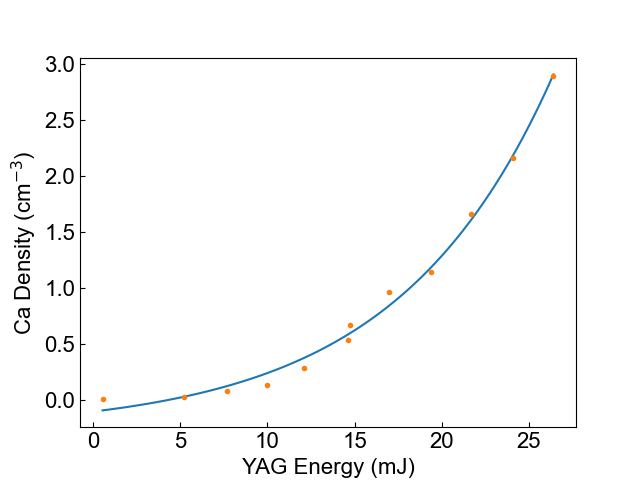

In [24]:
# Fit Ca production vs. YAG with no buffer gas present
def exp(x, a, b,c):
    return a*np.exp(b*x)+c

ca_pts = np.array([[7.6694915254237275, 0.07792207792207792],[9.95762711864407, 0.12987012987012986],
                [5.21186440677966, 0.025974025974025976],[0.5508474576271193, 0.008658008658008658],
                [12.118644067796609, 0.2857142857142857],[14.618644067796609, 0.5367965367965368],
                [14.745762711864407, 0.6666666666666666],[16.949152542372882, 0.961038961038961],
                [19.364406779661017, 1.1428571428571428],[21.694915254237287, 1.6536796536796536],
                [24.06779661016949, 2.155844155844156],[26.39830508474576, 2.8917748917748916]])
ca_yag = ca_pts[:,0]
ca = ca_pts[:,1]
popt_ca, pcov_ca = curve_fit(exp,ca_yag, ca)

yagx = np.linspace(min(ca_yag), max(ca_yag), 100)
plt.figure()
plt.plot(yagx, exp(yagx, *popt_ca), label = 'Fit')
plt.plot(ca_yag, ca, '.', label = 'Experimental data')
plt.xlabel('YAG Energy (mJ)')
plt.ylabel(r'Ca Density (cm$^{-3}$)')

In [25]:
# Helper functions. Thermalization time, elastic rate
def t_therm(Ts, Tbg, ms, mbg, nbg, k,  sig):
    '''
    Time for Ca to reach 30% of H2 temp
    Inputs:
    T, float
        Temperature [K]
    Tbg, float
        Buffer gas temp [K]
    mbg, float
        mass of buffer gas [au]
    nbg, float
        denisty of buffer gas [cm^-3]
    k, float
        mass ratio of molecule X:BG
        k = (m_X + m_BG)**2/(2*m_X*m_BG) # mass ratio between X and BG
    sig, float
        X-BG cross section [cm^2]
    '''
    # <v> = sqrt(8*kb*T/(pi*m)) MB Distribution
    vbg = np.sqrt(8*Tbg*1.38e-23/(np.pi*(mbg/u2me)*1.66e-27))*1e2 # [cm/s]
    vCa = np.sqrt(8*Ts*1.38e-23/(np.pi*(ms/u2me)*1.66e-27))*1e2 # [cm/s]
    vrel = np.sqrt(vbg**2 + vCa**2)
    r = rEl(nbg,vrel,sig)
    return -k/r*np.log((0.3*Tbg)/(Ts-Tbg))

def rEl(nbg, v, sigEl):
    '''
    Collision rate using relative velocity
    '''
    return nbg*v*sigEl

### Reaction model

In [26]:
# elastic cross sections
kb = 1.38e-23
amutokg = 1.66e-27

# Reaction model INCLUDING He buffer gas cooling of Ca
def changeT_full_He(t, y, TH2, THe, nHe, sig_CaH2, sig_CaHe):
    '''
    y, list
        Initial variables
    TH2, float
        H2 temp
    THe, float
        He temp
    nHe, float
        number density of He (cm^-3)
    sig_CaH2, float
        Elastic cross section between Ca and H2
    sig_CaHe, float
        Elastic cross section between Ca and He
    '''
    # Variables
    cah_i, ca_i, h20_i, h21_i, h22_i, h_i, T_Ca = y
    
    nH2 = h20_i + h21_i + h22_i
    
    # rate of collisions with BG
    vCa = np.sqrt(8*T_Ca*kb/(np.pi*(m_Ca/u2me)*amutokg))*1e2 # [cm/s]
    vH2 = np.sqrt(8*TH2*kb/(np.pi*(m_H2/u2me)*amutokg))*1e2 # [cm/s]
    vHe = np.sqrt(8*THe*kb/(np.pi*(m_He/u2me)*amutokg))*1e2 # [cm/s]
    
    vCaH2 = np.sqrt(vH2**2 + vCa**2)
    vCaHe = np.sqrt(vHe**2 + vCa**2)
    rH2 = rEl(nH2, vCaH2, sig_CaH2)
    rHe = rEl(nHe, vCaHe, sig_CaHe)
    
    # Equations
    
    # Changing T_Ca due to elastic collisions w/ H2 and He
    Tt_Ca = -rH2*(T_Ca - TH2)/k_CaH2 - rHe*(T_Ca - THe)/k_CaHe

    h0 = - fkq01(T_Ca)*h20_i*ca_i + fkq10(T_Ca)*h21_i*ca_i - fkr0(T_Ca)*h20_i*ca_i \
         - fkq02(T_Ca)*h20_i*ca_i + fkq20(T_Ca)*h22_i*ca_i# H2(0,0)
    
    h1 = fkq01(T_Ca)*h20_i*ca_i - fkq10(T_Ca)*h21_i*ca_i - fkr1(T_Ca)*h21_i*ca_i \
       - fkq12(T_Ca)*h21_i*ca_i + fkq21(T_Ca)*h22_i*ca_i # H2(1,0)
    
    h2 = fkq02(T_Ca)*h20_i*ca_i - fkq20(T_Ca)*h22_i*ca_i + fkq12(T_Ca)*h21_i*ca_i - \
         fkq21(T_Ca)*h22_i*ca_i - fkr2(T_Ca)*h22_i*ca_i # H2(2,0)
    
    c = - fkr0(T_Ca)*h20_i*ca_i - fkr1(T_Ca)*h21_i*ca_i - fkr2(T_Ca)*h22_i*ca_i  # Ca
    
    p = fkr0(T_Ca)*h20_i*ca_i + fkr1(T_Ca)*h21_i*ca_i + fkr2(T_Ca)*h22_i*ca_i # CaH
    
    h = p
    
    return [p,c,h0,h1,h2,h, Tt_Ca]


In [27]:
# Reaction model INCLUDING He buffer gas cooling of Ca
# Write function which randomly selects a rate from the normal distribution of rates
def k_rng(T, rate, rate_err, cutoff = 0):
    '''
    Recursively generate a random positive number for rate.
    '''
    while True:
        rate_rand = np.random.normal(rate(T), rate_err(T), 1)[0]
        return (rate_rand if rate_rand>=cutoff else k_rng(T, rate, rate_err))

def changeT_full_He_err(t, y, TH2, THe, nHe, sig_CaH2, sig_CaHe):
    '''
    y, list
        Initial variables
    TH2, float
        H2 temp
    THe, float
        He temp
    nHe, float
        number density of He (cm^-3)
    sig_CaH2, float
        Elastic cross section between Ca and H2
    sig_CaHe, float
        Elastic cross section between Ca and He
    '''

    # Variables
    cah_i, ca_i, h20_i, h21_i, h22_i, h_i, T_Ca = y
    
    nH2 = h20_i + h21_i + h22_i
    
    # rate of collisions with BG
    vCa = np.sqrt(8*T_Ca*kb/(np.pi*(m_Ca/u2me)*amutokg))*1e2 # [cm/s]
    vH2 = np.sqrt(8*TH2*kb/(np.pi*(m_H2/u2me)*amutokg))*1e2 # [cm/s]
    vHe = np.sqrt(8*THe*kb/(np.pi*(m_He/u2me)*amutokg))*1e2 # [cm/s]
    
    vCaH2 = np.sqrt(vH2**2 + vCa**2)
    vCaHe = np.sqrt(vHe**2 + vCa**2)
    rH2 = rEl(nH2, vCaH2, sig_CaH2)
    rHe = rEl(nHe, vCaHe, sig_CaHe)
    
    # Equations
    
    # Changing T_Ca due to elastic collisions w/ H2 and He
    Tt_Ca = -rH2*(T_Ca - TH2)/k_CaH2 - rHe*(T_Ca - THe)/k_CaHe
    
    fkq01_rand = k_rng(T_Ca,fkq01 , fkq01_err)
    fkq02_rand = k_rng(T_Ca,fkq02 , fkq02_err)
    fkq12_rand = k_rng(T_Ca,fkq12 , fkq12_err)
    fkq10_rand = k_rng(T_Ca,fkq10 , fkq10_err)
    fkq20_rand = k_rng(T_Ca,fkq20 , fkq20_err)
    fkq21_rand = k_rng(T_Ca,fkq21 , fkq21_err)
    fkr0_rand =  k_rng(T_Ca, fkr0, fkr0_err)
    fkr1_rand =  k_rng(T_Ca, fkr1, fkr1_err)
    fkr2_rand =  k_rng(T_Ca, fkr2, fkr2_err)
    
    h0 = - fkq01_rand*h20_i*ca_i + fkq10_rand*h21_i*ca_i - fkr0_rand*h20_i*ca_i \
        - fkq02_rand*h20_i*ca_i + fkq20_rand*h22_i*ca_i# H2(0,0)
    
    h1 = fkq01_rand*h20_i*ca_i - fkq10_rand*h21_i*ca_i - fkr1_rand*h21_i*ca_i \
        - fkq12_rand*h21_i*ca_i + fkq21_rand*h22_i*ca_i # H2(1,0)
    
    h2 = fkq02_rand*h20_i*ca_i - fkq20_rand*h22_i*ca_i + fkq12_rand*h21_i*ca_i - \
        fkq21_rand*h22_i*ca_i - fkr2_rand*h22_i*ca_i # H2(2,0)
    
    c = - fkr0_rand*h20_i*ca_i - fkr1_rand*h21_i*ca_i - fkr2_rand*h22_i*ca_i  # Ca
    
    p = fkr0_rand*h20_i*ca_i + fkr1_rand*h21_i*ca_i + fkr2_rand*h22_i*ca_i # CaH
    
    h = p

    z = [p,c,h0,h1,h2,h, Tt_Ca]
    return z

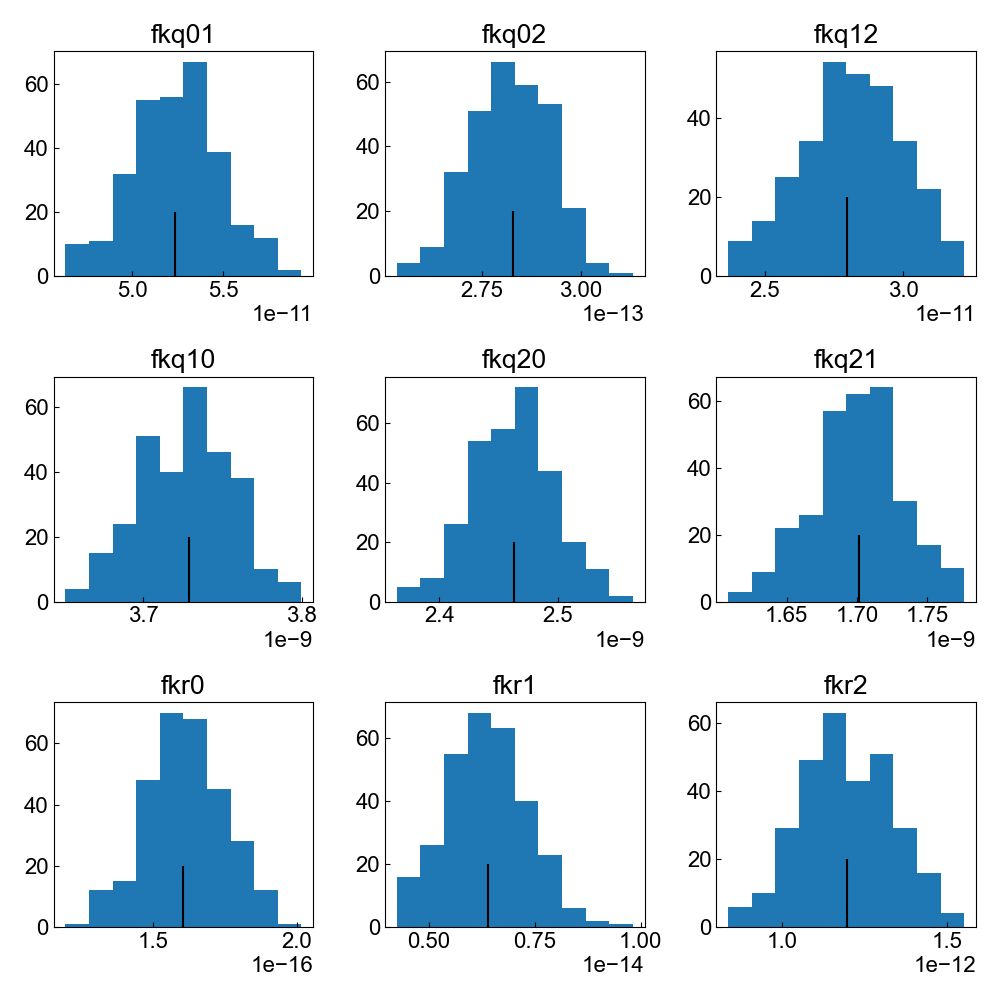

In [28]:
# Test for all positive rates
Tt = 1500
fkq01_rand = []
fkq02_rand = []
fkq12_rand = []
fkq10_rand = []
fkq20_rand = []
fkq21_rand = []
fkr0_rand  = []
fkr1_rand  = []
fkr2_rand  = []

for i in range(300):
    fkq01_rand.append(k_rng(Tt,fkq01 , fkq01_err))
    fkq02_rand.append(k_rng(Tt,fkq02 , fkq02_err))
    fkq12_rand.append(k_rng(Tt,fkq12 , fkq12_err))
    fkq10_rand.append(k_rng(Tt,fkq10 , fkq10_err))
    fkq20_rand.append(k_rng(Tt,fkq20 , fkq20_err))
    fkq21_rand.append(k_rng(Tt,fkq21 , fkq21_err))
    fkr0_rand .append(k_rng(Tt, fkr0, fkr0_err))
    fkr1_rand .append(k_rng(Tt, fkr1, fkr1_err))
    fkr2_rand .append(k_rng(Tt, fkr2, fkr2_err))
centers = np.asarray([fkq01,fkq02,fkq12,fkq10,
                    fkq20,fkq21,fkr0 ,fkr1 ,fkr2])
rates = np.asarray([fkq01_rand,fkq02_rand,fkq12_rand,fkq10_rand,
                    fkq20_rand,fkq21_rand,fkr0_rand ,fkr1_rand ,fkr2_rand])
rates_names = ['fkq01','fkq02','fkq12','fkq10',
                    'fkq20','fkq21','fkr0' ,'fkr1' ,'fkr2']

# print(fkq02_rand(Tt))
# # print([rates[i](Tt) for i in range(len(rates))])
# print(rates[0](Tt)[1],rates[1](Tt)[1],rates[2](Tt)[1],rates[3](Tt)[1])
fig, axs = plt.subplots(3,3, figsize = (10,10))
ax = axs.flatten()
for r in range(len(rates)):
    ax[r].set_title(f'{rates_names[r]}')
    ax[r].vlines(centers[r](Tt), 0, 20, 'k')
    count, bins, _ = ax[r].hist(rates[r], 10, density = False)
    # print(f'{rates_names[r]}: {count}, {bins}')
plt.tight_layout()

# plt.figure()
# count, bins, _  = plt.hist(fkr1_randerr, 10, density = False)
# plt.bar(x = [fkr1(T_0)],height = 20, width = fkr1_err(T_0), color = 'g', fill = False )


In [32]:
# One reaction example

sccmHe = 2 # SCCM
sccmH2 = 20 # SCCM

he_0 = sccmHe*u_sccmHe # initial H2 (0,0) concentration (cm^-3); old: (3e14 == 1sccm)
h20_0 = sccmH2*u_sccmH2 # initial H2 (0,0) concentration (cm^-3); old: (3e14 == 1sccm)
h21_0 = 0 # initial H2 (1,0) concentration
h22_0 = 0 # initial H2 (2,0) concentration

# Reaction gas
ca_0 = 91851128286590 # Initial Ca concentration
cah_0 = 0 # initial CaH concentration
h_0 = 0 # initial H concentration

# Elastic cross section
sig_CaH2 = 3.5e-16
sig_CaHe = 13.2e-16

# Buffer gas temp
TH2 = 6
THe = 6
TCa = 1600

# Change temperature
# T_0 = T_Ca(ca_0, min=TCa, max = TCa)
# T_0 = vTlinlog_Ca(ca_0)
# T_0 = vTloglog_Ca(ca_0)
T_0 = 2400 #K
y0 = [cah_0, ca_0, h20_0, h21_0, h22_0, h_0, T_0]
t_th_H2 = t_therm(T_0, TH2, m_Ca, m_H2, h20_0, k_CaH2, sig_CaH2)
t_th_He = t_therm(T_0, THe, m_Ca, m_He, he_0, k_CaHe, sig_CaHe)
tf = t_th_H2*2
t_span = [0, tf]
t_eval = np.linspace(min(t_span),max(t_span),100)

# # Dense output, no end
sol = integrate.solve_ivp(changeT_full_He, t_span = t_span,  y0 = y0, 
                          args = (TH2,THe, he_0, sig_CaH2, sig_CaHe), 
                          method = 'RK45', dense_output = True)
# Need to use RK45 to solve with errors!
sol_err = integrate.solve_ivp(changeT_full_He_err, t_span = t_span, y0 = y0, 
                          args = (TH2,THe, he_0, sig_CaH2, sig_CaHe), 
                          method = 'RK45', dense_output = True)

t = np.linspace(0, tf, 5000)
z = sol.sol(t)
z_rand = sol_err.sol(t)

if he_0 != 0:
    t_measure = t[np.where(z.T[:,-1] <= 1.1*((TH2 + THe)/2))[0][0]]
else:
    t_measure = t[np.where(z.T[:,-1] <= 1.1*TH2)[0][0]]
print(f'Thermalization for TCa = {T_0} K in {sccmH2} sccm H2  at {TH2} K and {sccmHe} sccm He at {THe} K: {t_measure} s')

Thermalization for TCa = 2400 K in 20 sccm H2  at 6 K and 2 sccm He at 6 K: 0.0017993338011000237 s


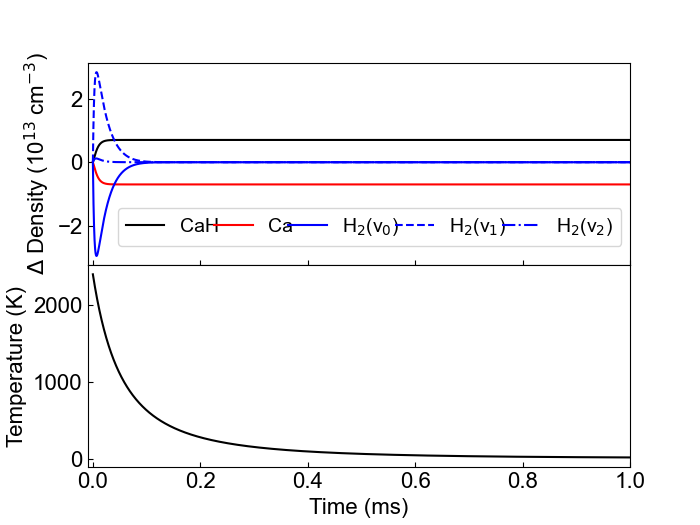

In [35]:
t = np.linspace(0, t_measure*1.1, 10000)
z = sol.sol(t)
# z_rand = sol_err.sol(t)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (7,7*4.8/6.4))
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize =  convocation (10,6))

# color = 'tab:red'
# ax1.plot(t*1e3, (z.T[:,0]*100 - (z.T[:,0][0]*100 - z.T[:,1][0]))/1e14, color = 'k', label = fr'CaH')# (+{np.abs(z.T[:,0][0]*100 - z.T[:,1][0]):.1g})')
# ax1.plot(t*1e3, (z.T[:,1]*100 - (z.T[:,1][1]*100 - z.T[:,1][0]))/1e14, color = 'r', label = fr'Ca')
# ax1.plot(t*1e3, (z.T[:,2] - (z.T[:,2][0] - z.T[:,1][0]))/1e14,         color = 'b' ,label = f'H$_2$(v$_0$) ') # (-{(z.T[:,2][0] - z.T[:,1][0]):.1g})')
# ax1.plot(t*1e3, (z.T[:,3] - (z.T[:,3][0] - z.T[:,1][0]))/1e14, '--',   color = 'b' ,label = f'H$_2$(v$_1$) ') #(+{np.abs(z.T[:,3][0] - z.T[:,1][0]):.1g})')
# ax1.plot(t*1e3, (z.T[:,4] - (z.T[:,4][0] - z.T[:,1][0]))/1e14, '-.',   color = 'b' ,label = f'H$_2$(v$_2$) ') #(+{np.abs(z.T[:,4][0] - z.T[:,1][0]):.1g})')

ax1.plot(t*1e3, (z.T[:,0] - z.T[:,0][0])*500/1e13, color = 'k', label = fr'CaH')# (+{np.abs(z.T[:,0][0]*100 - z.T[:,1][0]):.1g})')
ax1.plot(t*1e3, (z.T[:,1] - z.T[:,1][0])*500/1e13, color = 'r', label = fr'Ca')
ax1.plot(t*1e3, (z.T[:,2] - z.T[:,2][0])/1e13,         color = 'b' ,label = f'H$_2$(v$_0$) ') # (-{(z.T[:,2][0] - z.T[:,1][0]):.1g})')
ax1.plot(t*1e3, (z.T[:,3] - z.T[:,3][0])/1e13, '--',   color = 'b' ,label = f'H$_2$(v$_1$) ') #(+{np.abs(z.T[:,3][0] - z.T[:,1][0]):.1g})')
ax1.plot(t*1e3, (z.T[:,4] - z.T[:,4][0])/1e13, '-.',   color = 'b' ,label = f'H$_2$(v$_2$) ') #(+{np.abs(z.T[:,4][0] - z.T[:,1][0]):.1g})')
ax1.set_ylabel(fr'$\Delta$ Density (10$^{{13}}$ cm$^{{-3}}$)')

# ax1.plot(t*1e3, z.T[:,0])
# ax1.fill_between(t*1e3, z.T[:,0] - z_low.T[:,0], z.T[:,0] + z_high.T[:,0], alpha = 0.2)

# ax1.plot(t*1e3, (z_rand.T[:,0]*100 - (z_rand.T[:,0][0]*100 - z_rand.T[:,1][0]))/1e14, color = 'k', label = fr'CaH ($\times$100) (+{np.abs(z.T[:,0][0]*100 - z.T[:,1][0]):.1g})')
# ax1.plot(t*1e3, (z_rand.T[:,1]*100 - (z_rand.T[:,1][1]*100 - z_rand.T[:,1][0]))/1e14, color = 'r', label = fr'Ca ($\times$100) ')
# ax1.plot(t*1e3, (z_rand.T[:,2] - (z_rand.T[:,2][0] - z_rand.T[:,1][0]))/1e14,         color = 'b', label = f'H$_2$(v$_i$=0) (-{(z.T[:,2][0] - z.T[:,1][0]):.1g})')
# ax1.plot(t*1e3, (z_rand.T[:,3] - (z_rand.T[:,3][0] - z_rand.T[:,1][0]))/1e14, '--',   color = 'b', label = f'H$_2$(v$_i$=1) (+{np.abs(z.T[:,3][0] - z.T[:,1][0]):.1g})')
# ax1.plot(t*1e3, (z_rand.T[:,4] - (z_rand.T[:,4][0] - z_rand.T[:,1][0]))/1e14, '-.',   color = 'b', label = f'H$_2$(v$_i$=2) (+{np.abs(z.T[:,4][0] - z.T[:,1][0]):.1g})')
ymin, ymax = ax1.get_ylim()
ax1.set_ylim(ymin, ymax)
# ax1.set_xlim(right=0.4)
ax1.vlines(t_measure*1e3, ymin, ymax,linestyles='dashed', color = 'k')
# ax1.vlines(t_measure*1e3, 0.85, 1.13,linestyles='dashed', color = 'k')
ax1.legend(loc='lower left', fontsize=14, bbox_to_anchor=(0.02, 0, 1, 0.1),
                mode="expand", borderaxespad=1, ncol=5)
# ax1.set_yscale('log')


# ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

# color = 'tab:blue'
ax2.plot(t*1e3, z.T[:,-1], color = 'k')
ymin, ymax = ax2.get_ylim()
ax2.set_ylim(ymin, ymax)
ax2.vlines(t_measure*1e3, ymin, ymax,linestyles='dashed', color = 'k')
ax2.set_ylabel(r'Temperature (K)')  # we already handled the x-label with ax1
ax2.set_xlabel('Time (ms)')
# ax2.hlines(1.1*((TH2 + THe)/2), 0, max(t*1e3))
# ax2.vlines(t_measure*1e3, 0, 1.1*((TH2 + THe)/2))

ax2.set_xlim(-0.01,1)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.subplots_adjust(hspace=0)
# plt.savefig('samplereaction7.svg')


In [36]:
def detect(ca_0, init_cond):
    '''
    Function to mimic detection of molecules after a reaction. 
    Ends via terminal event, when Ca reaches the temperature average of H2 and He.

    ca_0, float
        Density of initial Ca atoms
        Positive influence on production
    init_cond, list
        Initial conditions containing:
        T_Ca, float
            Temperature of initial Ca atoms
            Positive influence on production
        TH2, float
            Temperature of H2 buffer gas
            Responsible for cooling H2 and suppressing the reaction
        THe, float
            Temperature of He buffer gas
            Responsible for cooling H2 and suppressing the reaction
        sccmH2, float
            Density of initial H2 atoms
            Responsible for cooling H2 and suppressing the reaction
        sccmHe, float
            Density of initial He atoms
            Responsible for cooling H2 and suppressing the reaction
        sig_CaH2, float
            Elastic cross section between Ca and H2
            Responsible for cooling H2 and suppressing the reaction
        sig_CaHe, float
            Elastic cross section between Ca and He
            Responsible for cooling H2 and suppressing the reaction
    '''
    T_Ca, TH2, THe, sccmH2, sccmHe, sig_CaH2, sig_CaHe = init_cond
    
    he_0 = sccmHe*u_sccmHe

    h20_0 = sccmH2*u_sccmH2 # initial H2 (0,0) concentration (cm^-3); old: (3e14 == 1sccm)
    h21_0 = 0 # initial H2 (1,0) concentration
    h22_0 = 0 # initial H2 (2,0) concentration

    # Reaction gas
    ca_0 = ca_0 # initial Ca concentration
    cah_0 = 0 # initial CaH concentration
    h_0 = 0 # initial H concentration

    # Change temperature
    y0 = [cah_0, ca_0, h20_0, h21_0, h22_0, h_0, T_Ca]
    t_th_H2 = t_therm(T_Ca, TH2, m_Ca, m_H2, h20_0, k_CaH2, sig_CaH2)
    # t_th_He = t_therm(T_Ca, THe, m_Ca, m_He, he_0, k_CaHe, sig_CaHe)
    # print(f'Thermalization times: H2: {t_th_H2}, He: {t_th_He}')
    tf = t_th_H2*5
    t_span = [0, tf]
    # t_eval = np.linspace(min(t_span),max(t_span),10000)
    
    # Solve ODEs
    # Find where Ca thermalizes to 130% of average temperature between H2 and He
    sol = integrate.solve_ivp(changeT_full_He, t_span = t_span, y0 = y0, 
                            args = (TH2,THe, he_0, sig_CaH2, sig_CaHe), 
                            method = 'RK45', dense_output = True)
    t = np.linspace(0, tf, 5000)
    z = sol.sol(t)
    
    if he_0 == 0:
        t_measure = t[np.where(z.T[:,-1] <= 1.3*(TH2))[0][0]]
    else:
        # t_measure = t[np.where(z.T[:,-1] <= 1.3*TH2)[0][0]]
        t_measure = t[np.where(z.T[:,-1] <= 1.3*((TH2 + THe)/2))[0][0]]


    # print(f'Thermalization for TCa = {T_Ca} K in {sccmH2} sccm H2 at {TH2} K and {sccmHe} sccm He at {THe} K: {t_measure} s')
    z_cap = sol.sol(t_measure)
    
    return z_cap
    
def detect_rand(ca_0, init_cond):
    '''
    Function to mimic detection of molecules after a reaction. 
    Ends via terminal event, when Ca reaches the temperature average of H2 and He.


    ca_0, float
        Density of initial Ca atoms
        Positive influence on production
    init_cond, list
        Initial conditions containing:
        T_Ca, float
            Temperature of initial Ca atoms
            Positive influence on production
        TH2, float
            Temperature of H2 buffer gas
            Responsible for cooling H2 and suppressing the reaction
        THe, float
            Temperature of He buffer gas
            Responsible for cooling H2 and suppressing the reaction
        sccmH2, float
            Density of initial H2 atoms
            Responsible for cooling H2 and suppressing the reaction
        sccmHe, float
            Density of initial He atoms
            Responsible for cooling H2 and suppressing the reaction
        sig_CaH2, float
            Elastic cross section between Ca and H2
            Responsible for cooling H2 and suppressing the reaction
        sig_CaHe, float
            Elastic cross section between Ca and He
            Responsible for cooling H2 and suppressing the reaction
    '''
    T_Ca, TH2, THe, sccmH2, sccmHe, sig_CaH2, sig_CaHe = init_cond
    he_0 = sccmHe*u_sccmHe

    h20_0 = sccmH2*u_sccmH2 # initial H2 (0,0) concentration (cm^-3); old: (3e14 == 1sccm)
    h21_0 = 0 # initial H2 (1,0) concentration
    h22_0 = 0 # initial H2 (2,0) concentration

    # Reaction gas
    ca_0 = ca_0 # initial Ca concentration
    cah_0 = 0 # initial CaH concentration
    h_0 = 0 # initial H concentration

    # Change temperature
    y0 = [cah_0, ca_0, h20_0, h21_0, h22_0, h_0, T_Ca]
    t_th_H2 = t_therm(T_Ca, TH2, m_Ca, m_H2, h20_0, k_CaH2, sig_CaH2)
    # t_th_He = t_therm(T_Ca, THe, m_Ca, m_He, he_0, k_CaHe, sig_CaHe)
    # print(f'Thermalization times: H2: {t_th_H2}, He: {t_th_He}')
    tf = t_th_H2*5
    t_span = [0, tf]
    # t_eval = np.linspace(min(t_span),max(t_span),10000)
    
    # Solve ODEs
    # Find where Ca thermalizes to 130% of average temperature between H2 and He
    sol_rand= integrate.solve_ivp(changeT_full_He_err, t_span = t_span, y0 = y0, 
                                args = (TH2,THe, he_0, sig_CaH2, sig_CaHe), 
                                method = 'RK45', dense_output = True)
    t = np.linspace(0, tf, 5000)
    z = sol_rand.sol(t)
    
    # Measure at T = 1.3*(Tbg)
    if he_0 == 0:
        t_measure = t[np.where(z.T[:,-1] <= 1.3*(TH2))[0][0]]
    else:
        # t_measure = t[np.where(z.T[:,-1] <= 1.3*TH2)[0][0]]
        t_measure = t[np.where(z.T[:,-1] <= 1.3*((TH2 + THe)/2))[0][0]]


    # print(f'Thermalization for TCa = {T_Ca} K in {sccmH2} sccm H2 at {TH2} K and {sccmHe} sccm He at {THe} K: {t_measure} s')
    z_cap = sol_rand.sol(t_measure)
    return z_cap

In [37]:
# Detect function usage
sig_CaH2 = 3.5e-16
sig_CaHe = 13.2e-16

TH2 = 6
THe = 6
ca_0 = 1e13
TCa_0 = 2400 # Constant temperature
sccmH2 = 20
sccmHe = 2
# TCa_0 = vTlinlog_Ca(ca_0) # Linear T vs. YAG, exponential Ca vs. YAG
# TCa_0 = vTloglog_Ca(ca_0) # Logarithmic T vs. YAG, exponential Ca vs. YAG 

init_c = TCa_0, TH2, THe, sccmH2, sccmHe, sig_CaH2, sig_CaHe
ztest = detect(ca_0, init_c)
ztest_rand = detect_rand(ca_0, init_c)
cah, ca, h20, h21, h22, h, Tf = ztest
cah_rand, ca_rand, h20_rand, h21_rand, h22_rand, h_rand, Tf_rand = ztest_rand
print(cah/ca)
print(cah_rand/ca_rand) 

0.00010228212791195477
0.00010185796350120716


In [38]:
# Test statistics
cah_rand = []
ca_rand = []
for i in tqdm(range(100)):
    ztest_rand = detect_rand(ca_0, init_c)
    cah_rand.append(ztest_rand[0])
    ca_rand.append(ztest_rand[1])

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'PDF')

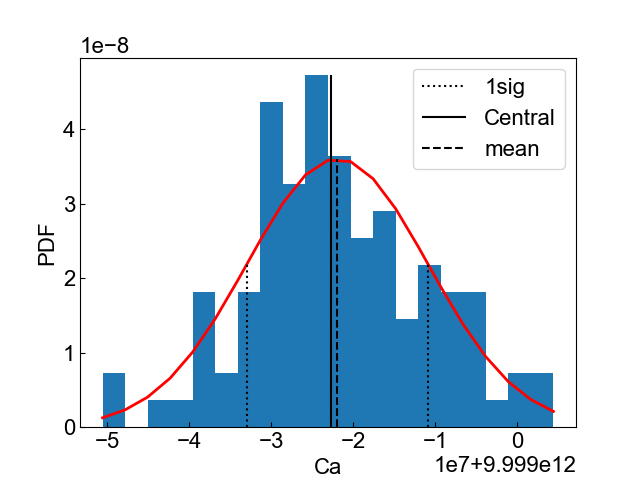

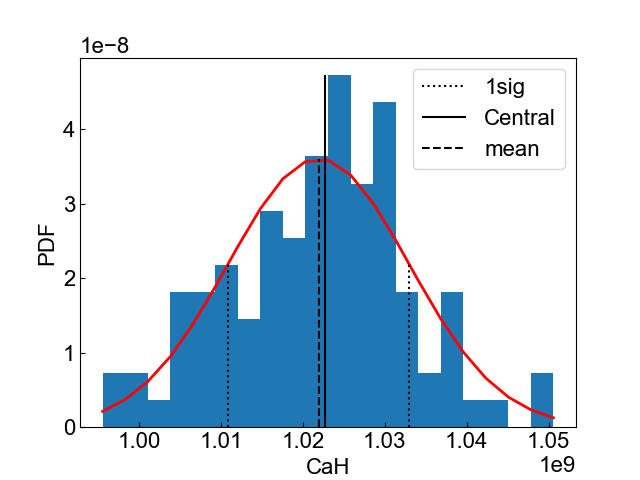

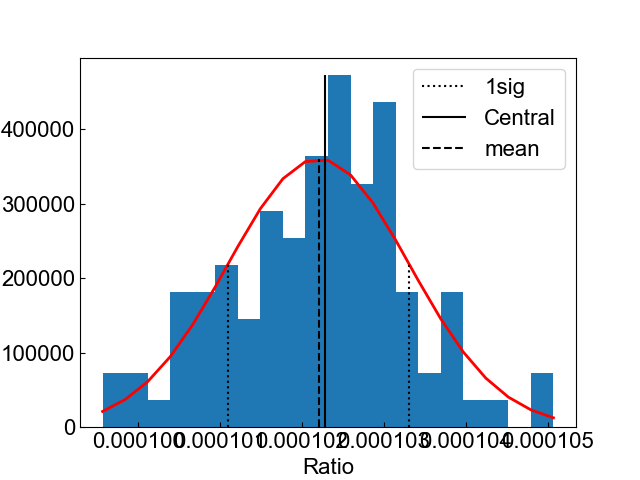

In [39]:
rats_rand = np.asarray(cah_rand)/np.asarray(ca_rand)

plt.figure()
# plt.vlines(ca, 0, 10, 'k')
counts, bins, _ = plt.hist(ca_rand, bins = 20, density=True)
plt.plot(bins, 1/(np.std(ca_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - np.mean(ca_rand))**2 / (2 * np.std(ca_rand)**2) ),
         linewidth=2, color='r')
plt.vlines(np.mean(ca_rand) - np.std(ca_rand), 
           0,
           1/(np.std(ca_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - ( - np.std(ca_rand) )**2 / (2 * np.std(ca_rand)**2)), 'k', linestyles= 'dotted',label = '1sig')
plt.vlines(np.mean(ca_rand) + np.std(ca_rand), 
           0,
           1/(np.std(ca_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - ( - np.std(ca_rand) )**2 / (2 * np.std(ca_rand)**2)), 'k', linestyles= 'dotted')
plt.vlines(ca, 0, max(counts), 'k', label = 'Central')
plt.vlines(np.mean(ca_rand), 0, 1/(np.std(ca_rand) * np.sqrt(2 * np.pi)), 'k',linestyles='dashed', label = 'mean')
plt.xlabel('Ca')
plt.ylabel('PDF')
plt.legend()

plt.figure()
# plt.vlines(cah, 0, 10, 'k')
counts, bins, _ = plt.hist(cah_rand, bins = 20, density=True)
plt.plot(bins, 1/(np.std(cah_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - np.mean(cah_rand))**2 / (2 * np.std(cah_rand)**2) ),
         linewidth=2, color='r')
plt.vlines(np.mean(cah_rand) - np.std(cah_rand), 
           0,
           1/(np.std(cah_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - ( - np.std(cah_rand) )**2 / (2 * np.std(cah_rand)**2)), 'k', linestyles= 'dotted',label = '1sig')
plt.vlines(np.mean(cah_rand) + np.std(cah_rand), 
           0,
           1/(np.std(cah_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - ( - np.std(cah_rand) )**2 / (2 * np.std(cah_rand)**2)), 'k', linestyles= 'dotted')
plt.vlines(cah, 0, max(counts), 'k', label = 'Central')
plt.vlines(np.mean(cah_rand), 0, 1/(np.std(cah_rand) * np.sqrt(2 * np.pi)), 'k',linestyles='dashed', label = 'mean')
plt.xlabel('CaH')
plt.ylabel('PDF')
plt.legend() 

plt.figure()
counts, bins, _ = plt.hist(rats_rand, bins = 20, density=True)
plt.plot(bins, 1/(np.std(rats_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - np.mean(rats_rand))**2 / (2 * np.std(rats_rand)**2) ),
         linewidth=2, color='r')
plt.vlines(np.mean(rats_rand) - np.std(rats_rand), 
           0,
           1/(np.std(rats_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - ( - np.std(rats_rand) )**2 / (2 * np.std(rats_rand)**2)), 'k', linestyles= 'dotted',label = '1sig')
plt.vlines(np.mean(rats_rand) + np.std(rats_rand), 
           0,
           1/(np.std(rats_rand) * np.sqrt(2 * np.pi)) *
               np.exp( - ( - np.std(rats_rand) )**2 / (2 * np.std(rats_rand)**2)), 'k', linestyles= 'dotted')
plt.vlines(cah/ca, 0, max(counts), 'k', label = 'Central')
plt.vlines(np.mean(rats_rand), 0, 1/(np.std(rats_rand) * np.sqrt(2 * np.pi)), 'k',linestyles='dashed', label = 'mean')
plt.legend()
plt.xlabel('Ratio')
plt.ylabel('PDF')

In [ ]:
####### UNCOMMENT TO RUN, WILL TAKE SEVERAL HOURS ########## 
# Full calculation

# ca_n = [10**x for x in np.arange(12,15,0.1)] # 30 datapoints

# TCa_0 = 2400 # Best fit value, pm 60 K
# TH2 = 6 # K
# THe = 6 # K
# sccmH2 = 20
# sccmHe = 2

# sig_CaH2 = 3.5e-16
# sig_CaHe = 13.2e-16

# ca_rand_dict = {} # Keys: Ca concentration, Values: ca, cah, ca_err, cah_err
# ca_center = {} # Keys: Ca concentration, Values: ca, cah, ratio

# init_c = [TCa_0, TH2, THe, sccmH2, sccmHe, sig_CaH2, sig_CaHe]
# for ca_i in tqdm(ca_n):
#     z = detect(ca_i,init_c) # No error
#     cah, ca, h20, h21, h22, h, Tf = z
#     ca_center[ca_i] = ca, cah, cah/ca
    
#     cah_rand = []
#     ca_rand = []
#     for i in tqdm(range(100), leave = False):
#         try:
#             ztest_rand = detect_rand(ca_i, init_c)
#             cah_rand.append(ztest_rand[0])
#             ca_rand.append(ztest_rand[1])
#         except:
#             cah_rand.append([np.nan])
#             ca_rand.append([np.nan])
#     cah_r = np.nanmean(np.array(cah_rand))
#     ca_r = np.nanmean(np.array(ca_rand))
#     cah_r_err = np.nanstd(np.array(cah_rand))
#     ca_r_err = np.nanstd(np.array(ca_rand))
#     ca_rand_dict[ca_i] = ca_r, cah_r, ca_r_err, cah_r_err

# Unpack final results
# ca_r, cah_r, ca_err, cah_err = np.asarray([np.asarray(list(ca_rand_dict.values()))[:,i] for i in range(4)])
# ca, cah, rat = np.asarray([np.asarray(list(ca_center.values()))[:,i] for i in range(3)])
# rat_err = rat*np.sqrt(np.square(cah_err/cah) + np.square(ca_err/ca))
# rat_high = rat + rat_err
# rat_low = rat - rat_err

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
# Results of above cells on 30 datapoints:

ca, cah, rat = \
	np.array(([9.99924347e+11, 1.25882886e+12, 1.58476962e+12, 1.99510362e+12,
			2.51168188e+12, 3.16201292e+12, 3.98072756e+12, 5.01142304e+12,
			6.30898449e+12, 7.94250730e+12, 9.99897728e+12, 1.25879018e+13,
			1.58471425e+13, 1.99502562e+13, 2.51157387e+13, 3.16186601e+13,
			3.98053142e+13, 5.01116607e+13, 6.30865414e+13, 7.94209087e+13,
			9.99846207e+13, 1.25872766e+14, 1.58463979e+14, 1.99493859e+14,
			2.51147393e+14, 3.16175321e+14, 3.98040613e+14, 5.01102898e+14,
			6.30850616e+14, 7.94193306e+14],
			[7.56533056e+07, 9.65502859e+07, 1.23570683e+08, 1.58691912e+08,
			2.04555182e+08, 2.64736112e+08, 3.44143122e+08, 4.49299530e+08,
			5.88953430e+08, 7.75042462e+08, 1.02271667e+09, 1.35232667e+09,
			1.78942240e+09, 2.36694411e+09, 3.12557509e+09, 4.11652619e+09,
			5.40284630e+09, 7.06263266e+09, 9.19306884e+09, 1.19147793e+10,
			1.53792928e+10, 1.97748831e+10, 2.53398662e+10, 3.23726370e+10,
			4.12502954e+10, 5.24454005e+10, 6.65575110e+10, 8.43353463e+10,
			1.06728976e+11, 1.34928698e+11],
			[7.56590294e-05, 7.66985003e-05, 7.79739094e-05, 7.95406864e-05,
			8.14415169e-05, 8.37239183e-05, 8.64523172e-05, 8.96550793e-05,
			9.33515419e-05, 9.75815864e-05, 1.02282128e-04, 1.07430666e-04,
			1.12917670e-04, 1.18642291e-04, 1.24446871e-04, 1.30192936e-04,
			1.35731784e-04, 1.40937909e-04, 1.45721554e-04, 1.50020687e-04,
			1.53816584e-04, 1.57102157e-04, 1.59909314e-04, 1.62273852e-04,
			1.64247357e-04, 1.65874428e-04, 1.67212864e-04, 1.68299458e-04,
			1.69182646e-04, 1.69894026e-04]))

ca_err, cah_err, rat_high, rat_low = \
        np.array(([1.06850725e+06, 1.28387190e+06, 1.50210933e+06, 1.99636214e+06,
				2.21490515e+06, 3.31654938e+06, 5.08186652e+06, 4.52731070e+06,
				6.92668888e+06, 9.44825647e+06, 1.10162959e+07, 1.51213418e+07,
				1.93951295e+07, 2.95009146e+07, 3.55223732e+07, 4.17125578e+07,
				6.58991880e+07, 8.70483810e+07, 8.97320216e+07, 1.27177181e+08,
				1.44577541e+08, 2.02255423e+08, 2.64380030e+08, 3.09174941e+08,
				2.99054627e+08, 3.85139037e+08, 4.27264982e+08, 5.76141514e+08,
				6.80547379e+08, 6.62719018e+08],
				[1.06850725e+06, 1.28387190e+06, 1.50210933e+06, 1.99636214e+06,
				2.21490515e+06, 3.31654938e+06, 5.08186652e+06, 4.52731070e+06,
				6.92668888e+06, 9.44825647e+06, 1.10162959e+07, 1.51213418e+07,
				1.93951295e+07, 2.95009146e+07, 3.55223732e+07, 4.17125578e+07,
				6.58991880e+07, 8.70483810e+07, 8.97320216e+07, 1.27177181e+08,
				1.44577541e+08, 2.02255423e+08, 2.64380030e+08, 3.09174941e+08,
				2.99054627e+08, 3.85139037e+08, 4.27264982e+08, 5.76141514e+08,
				6.80547379e+08, 6.62719018e+08],
				[7.67276175e-05, 7.77183943e-05, 7.89217502e-05, 8.05413172e-05,
				8.23233583e-05, 8.47727911e-05, 8.77289347e-05, 9.05584775e-05,
				9.44494506e-05, 9.87711674e-05, 1.03383870e-04, 1.08631926e-04,
				1.14141558e-04, 1.20121015e-04, 1.25861218e-04, 1.31512175e-04,
				1.37387321e-04, 1.42674997e-04, 1.47143918e-04, 1.51621993e-04,
				1.55262582e-04, 1.58708982e-04, 1.61577705e-04, 1.63823649e-04,
				1.65438110e-04, 1.67092547e-04, 1.68286285e-04, 1.69449205e-04,
				1.70261424e-04, 1.70728481e-04],
				[7.45904413e-05, 7.56786064e-05, 7.70260686e-05, 7.85400556e-05,
				8.05596754e-05, 8.26750455e-05, 8.51756997e-05, 8.87516810e-05,
				9.22536332e-05, 9.63920053e-05, 1.01180386e-04, 1.06229406e-04,
				1.11693782e-04, 1.17163568e-04, 1.23032524e-04, 1.28873697e-04,
				1.34076246e-04, 1.39200820e-04, 1.44299190e-04, 1.48419381e-04,
				1.52370586e-04, 1.55495333e-04, 1.58240922e-04, 1.60724056e-04,
				1.63056603e-04, 1.64656309e-04, 1.66139444e-04, 1.67149711e-04,
				1.68103869e-04, 1.69059570e-04]))

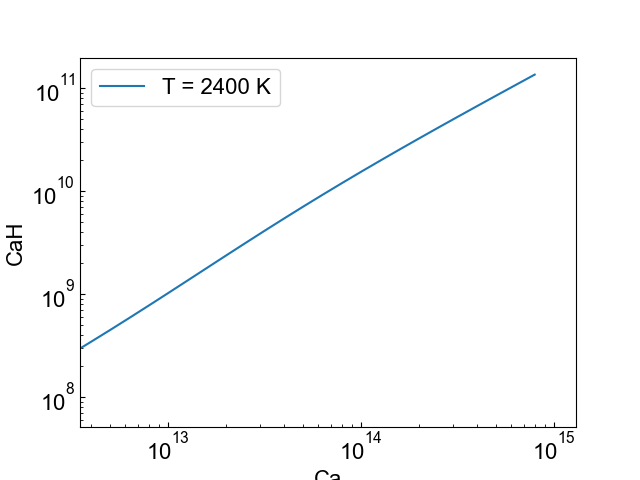

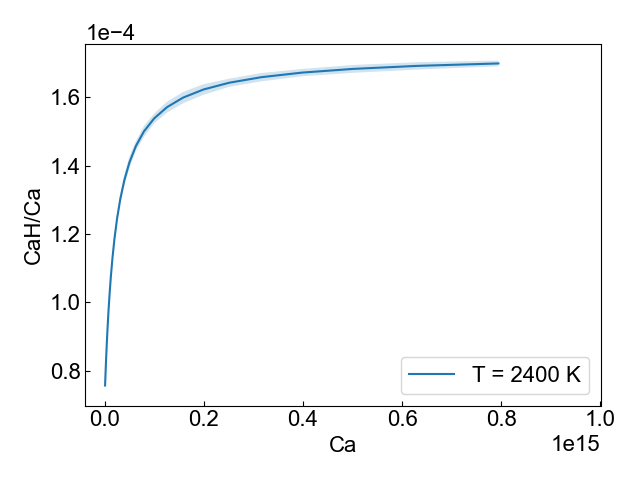

In [73]:
cah_high  = cah + cah_err
cah_low = cah - cah_err

plt.figure()
plt.plot(ca, cah, label = f'T = {T_0} K')
plt.fill_between(ca, cah_high, cah_low, alpha = 0.2)
plt.xlim(3.5e12,1.3e15)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ca')
plt.ylabel('CaH')
plt.legend()

# Plot ratios
plt.figure()
plt.plot(ca, rat, label = f'T = {T_0} K')
plt.fill_between(ca, rat_high, rat_low, alpha = 0.2)
plt.xlim(right = 1e15)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Ca')
plt.ylabel('CaH/Ca')
plt.legend()
plt.tight_layout()
